In [89]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------

def drive1(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive2(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = -signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive3(t, args):    # square cos wave transverse
    w = args['omega']
    h0 = args['h0']
    h = args['h']
    T = 2 * np.pi/w

    sint = -np.sin(w*t)
    if sint<=0:
        sint = 0
    sqrsin = h0 + h * sint
    return sqrsin

def get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H10, H11, H12, H21, H22, H23, H24 =  empt, empt, empt, empt, empt, empt, empt
    
    ##-- Hamiltonian ------------------------------------------- 
    ##-- First half

    for i in range(N1):  
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-ea)

    for i in range(N1,N):  
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-eb)   

    ##-- Second half

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sy, tensor(id1, tensor(sy,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) * lambd_x

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H24 = H24 + Qobj(tensor(id,tensor(sy,id1)).full()) * lambd_y
    
    return H11, H12, H21, H22, H23, H24

##-- Dynamics
def run_dynm(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,opts,sz_s = args['h0'],args['h'],args['times'],args['opts'], args['sz_s']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], sz_s, args = params)
    return out.expect, beta, Jvalue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.74s/it]


CPU times: user 2.45 s, sys: 604 ms, total: 3.06 s
Wall time: 53.8 s


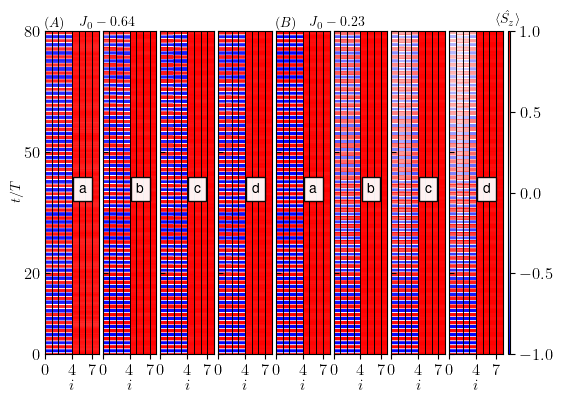

In [88]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm
#from funcs import *
import h5py
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams.update({"figure.figsize": (6,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})


fig = plt.figure()
grid = ImageGrid(fig, 111,nrows_ncols = (1,8),axes_pad = 0.04,
                 cbar_location = "right",
                 cbar_mode="single",cbar_size="4%", cbar_pad=0.05
                )

freezing_pts = jn_zeros(0, 3)

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 80 * T, 800, endpoint=False)

ea, eb = 0.03, 0.9
lambd_y = 0
lambd_x = 0

ft = 10   
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]   
Jlbl = [r'$J_0 = 0.072/T$',r'$J_0=0.2/T$'] 
betas = [0, 1.5, 2.5, float('inf')]
labels = ['a','b', 'c', 'd', 'a','b', 'c', 'd']

nprocs = 4
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

     
spinposition_A = [0,1,2,3]
spinposition_B = [4,5,6,7]  
  
h0 = 0.0
h = freezing_pts[0] * w/4 
sx,sy,sz = sigmax(), sigmay(), sigmaz()

sz_s = []

# Region A
for m,i in enumerate(spinposition_A):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_s.append(Qobj(tensor(id,tensor(sz,id1)).full()))

# Region B
for m,i in enumerate(spinposition_B):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_s.append(Qobj(tensor(id,tensor(sz,id1)).full()))


# Weak couling parameters 
params1 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
           'opts':opts, 'sz_s':sz_s, 'lambd_y':lambd_y,\
           'lambd_x':lambd_x, 'Jvalue':Jvalues[0],'beta':beta,\
           'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]

# Strong couling parameters 
params2 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
           'opts':opts, 'sz_s':sz_s, 'lambd_y':lambd_y,\
           'lambd_x':lambd_x, 'Jvalue':Jvalues[1],'beta':beta,\
           'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]

params = params2 + params1   # strong + weak :coupling

data = p.map(run_dynm,tqdm(params))

datap = np.zeros((N, len(times)))
xx= 0
for i in range(N):
    datap = np.array(data[i][0])
    beta = data[i][1]
    Jvalue = data[i][2]

    xx = int(xx)
    imc = grid[xx].imshow(datap.T, aspect=0.6,interpolation="nearest",\
                    cmap='bwr', origin='lower',extent = [0 , N, times[0]/T , times[-1]/T],\
                    vmax=1, vmin=-1)
    grid[xx].text(5, 40, labels[i], fontsize=10, bbox=dict(facecolor='white', alpha=0.95))
    for i in range(N):
        grid[xx].axvline(i,color = 'black', linewidth=0.7)
    grid[xx].set_xlabel(r'$i$', fontsize=11, labelpad=0.0)
    grid[xx].set_ylabel(r'$t/T$', fontsize=10, labelpad=0.0)
    grid[xx].set_yticks([0,20,50,80])
    grid[xx].set_xticks([0,4,7])
    grid[xx].tick_params(which='both', axis="y", direction="in")
    xx=xx+1

grid[0].text(0, 81, fr"$(A)$", fontsize=10)
grid[4].text(0, 81, fr"$(B)$", fontsize=10)

grid[0].text(5, 81, fr"$  J_0 -{Jvalues[1]:2.2f}$", fontsize=10)
grid[4].text(5, 81, fr"$  J_0 -{Jvalues[0]:2.2f}$", fontsize=10)

cbticks = np.linspace(-1,1,5)
clb = plt.colorbar(imc, cax=grid.cbar_axes[0], ticks= cbticks, aspect=30) 
clb.ax.set_title(label=r"$\langle\hat{S_z}\rangle$", fontsize = 10)     
figname = "sz_t_strongJ_N_" + str(N) +'_ea_' + str(ea) + '_eb_' + str(eb) +'.svg'
plt.savefig(figname, bbox_inches='tight', pad_inches=0.0, dpi=300)

# Now change and update the codes for figures,

## 1. Strong and weak coupling at CDT/DL point and away from it

0 12.024127788478864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.04s/it]


1 17.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:27<00:00,  3.45s/it]


CPU times: user 3.26 s, sys: 136 ms, total: 3.39 s
Wall time: 1min 23s


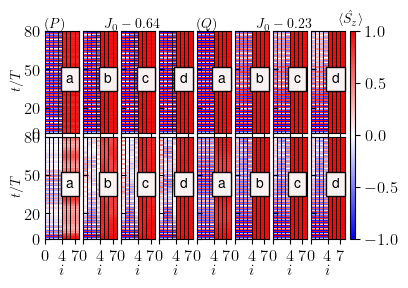

In [101]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm
#from funcs import *
import h5py
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams.update({"figure.figsize": (8,12),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})


fig = plt.figure()
grid = ImageGrid(fig, 111,nrows_ncols = (2,8),axes_pad = 0.04,
                 cbar_location = "right",
                 cbar_mode="single",cbar_size="8%", cbar_pad=0.05
                )
plt.subplots_adjust(wspace=0.02, hspace=0.1)
freezing_pts = jn_zeros(0, 3)

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 80 * T, 800, endpoint=False)

ea, eb = 0.03, 0.9
lambd_y = 0
lambd_x = 0

ft = 10   
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]   
Jlbl = [r'$J_0 = 0.072/T$',r'$J_0=0.2/T$'] 
betas = [0, 1.5, 2.5, float('inf')]
labels = ['a','b', 'c', 'd', 'a','b', 'c', 'd']

nprocs = 3
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

     
spinposition_A = [0,1,2,3]
spinposition_B = [4,5,6,7]  
  
h0 = 0.0
hs = [freezing_pts[0] * w/4 , 3.5 * w/4]
sx,sy,sz = sigmax(), sigmay(), sigmaz()

sz_s = []

# Region A
for m,i in enumerate(spinposition_A):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_s.append(Qobj(tensor(id,tensor(sz,id1)).full()))

# Region B
for m,i in enumerate(spinposition_B):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_s.append(Qobj(tensor(id,tensor(sz,id1)).full()))

xx = 0

for hh, h in enumerate(hs):
    print(hh,h)
    
    # Weak couling parameters 
    params1 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
               'opts':opts, 'sz_s':sz_s, 'lambd_y':lambd_y,\
               'lambd_x':lambd_x, 'Jvalue':Jvalues[0],'beta':beta,\
               'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]
    
    # Strong couling parameters 
    params2 = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
               'opts':opts, 'sz_s':sz_s, 'lambd_y':lambd_y,\
               'lambd_x':lambd_x, 'Jvalue':Jvalues[1],'beta':beta,\
               'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]
    
    params = params2 + params1   # strong + weak :coupling
    
    data = p.map(run_dynm,tqdm(params))
    
    datap = np.zeros((N, len(times)))
    
    for i in range(N):
        datap = np.array(data[i][0])
        beta = data[i][1]
        Jvalue = data[i][2]
    
        xx = int(xx)
        imc = grid[xx].imshow(datap.T, aspect=0.3,interpolation="nearest",\
                        cmap='bwr', origin='lower',extent = [0 , N, times[0]/T , times[-1]/T],\
                        vmax=1, vmin=-1)
        grid[xx].text(5, 40, labels[i], fontsize=10, bbox=dict(facecolor='white', alpha=0.95))
        for i in range(N):
            grid[xx].axvline(i,color = 'black', linewidth=0.7)
        grid[xx].set_xlabel(r'$i$', fontsize=11, labelpad=0.0)
        grid[xx].set_ylabel(r'$t/T$', fontsize=10, labelpad=0.0)
        grid[xx].set_yticks([0,20,50,80])
        grid[xx].set_xticks([0,4,7])
        grid[xx].tick_params(which='both', axis="y", direction="in")

        xx=xx+1
        
grid[0].text(0, 82, fr"$(P)$", fontsize=10)
grid[4].text(0, 82, fr"$(Q)$", fontsize=10)
grid[1].text(5, 82, fr"$ J_0 -{Jvalues[1]:2.2f}$", fontsize=10)
grid[5].text(5, 82, fr"$  J_0 -{Jvalues[0]:2.2f}$", fontsize=10)

cbticks = np.linspace(-1,1,5)
clb = plt.colorbar(imc, cax=grid.cbar_axes[0], ticks= cbticks, aspect=30) 
clb.ax.set_title(label=r"$\langle\hat{S_z}\rangle$", fontsize = 10)     
figname = "sz_t_strongJ_N_" + str(N) +'_ea_' + str(ea) + '_eb_' + str(eb) +'.svg'
plt.savefig(figname, bbox_inches='tight', pad_inches=0.0, dpi=300)